In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Operator

from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Math, Latex
import math

# Quantum Fourier Transform

In Quantum Computing the Quantum Fourier Transform (QFT), is the quantum analogue of the classical Fast Fourier Transform, which define a linear transformation on a string of qubits, that applies controlled phase shifts onto a superposition state. This operation is pretty well-known for its importance on many Quantum Algorithms, notably Shor's Algorithm, for factoring and computing the discrete logarithm, Quantum Phase Estimation for estimating the eigenvalues of a unitary operator, and algorithms for the hidden subgroup problem.

## The Period Finding Problem

So, let $f:\{0,\dots, M-1\} \rightarrow \{0,\dots, M-1\}$ be a periodic function of period $r$, so that $\forall x \in \{0,\dots, M-r-1\}$, we have that $f(x) = f(x+r)$, and all the values $f(x), f(x+1),\dots f(x+r-1)$ are different. We have that our goal is to find the value $r$ that defines the period.

In order to extract this information from a quantum state on $n$ qubits, which in superposition give us $N = 2^n$ states, we can use the Quantum Fourier Transform and implement it in a Quantum Computer with $\mathcal{O}(n^2)$ elementary gates. Therefore, giving us an exponential speed up when compared with the classical Fast Fourier Transform, which takes $\mathcal{O}(NlogN) = \mathcal{O}(2^nn)$ to solve the problem. However both functions don't have the same output, since QFT won’t give us the entries of the Fourier transform written down, but only as the amplitudes of the resulting measured states.

<img src="images/fourier_meme.jpg" style="width:400px; height:200px"/>

## The Algorithm

Effectvely the QFT is just a change of basis from the Computational Basis to the Fourier Basis, one small example that we already know is given by the function $f$ that takes a single qubit 

$$
      f:\{|0\rangle, |1\rangle\} \rightarrow \{|+\rangle, |-\rangle\} 
$$

which is clearly done by the Hadarmard gate $H$, a single qubit QFT. Therefore, to the general case on state of $n$ qubits $|x\rangle$ we define the QFT as follows

$$
    |\chi\rangle = QFT|x\rangle = \frac{1}{\sqrt{N}}\sum_{y = 0}^{N-1}\exp\bigg(\frac{2\pi i xy}{N}\bigg)|y\rangle
$$

Hence, from that definition we can extract our single-qubit $\{|0\rangle, |1\rangle\}$ example, so let $N = 2$

$$
\begin{align*}
    QFT|x\rangle &= \frac{1}{\sqrt{2}}\sum_{y = 0}^{N-1}\exp\bigg(\frac{2\pi ixy}{2}\bigg)|y\rangle\\
                 &= \frac{1}{\sqrt{2}}\bigg[e^{i\pi x0}|0\rangle + e^{i\pi x1}|1\rangle\bigg]\\
                 &= \frac{1}{\sqrt{2}}\bigg[|0\rangle + e^{i\pi x}|1\rangle\bigg]\\                    
                 &= \begin{cases} |+\rangle, & \mbox{if } |x\rangle = |0\rangle\\ |-\rangle, & \mbox{if } |x\rangle = |1\rangle \end{cases}\\
\end{align*}
$$

Now, expanding this from the general definition above on $n$ qubits we have that

$$
\begin{align*}
    |\chi\rangle &= \frac{1}{\sqrt{N}}\sum_{y = 0}^{N-1}\exp\bigg(\frac{2\pi i xy}{N}\bigg)|y\rangle\\
                 &= \frac{1}{\sqrt{N}}\sum_{y = 0}^{N-1}\exp\bigg(2\pi ix\sum_{k = 1}^{n}\frac{y^k}{2^k}\bigg)|y_1 y_2 \dots y_n\rangle\\
                 &= \frac{1}{\sqrt{N}}\sum_{y = 0}^{N-1}\displaystyle\prod_{k = 1}^{n}\exp\bigg(2\pi ix\frac{y^k}{2^k}\bigg)|y_1 y_2 \dots y_n\rangle\\                    
                 &= \frac{1}{\sqrt{N}}\bigotimes_{k = 1}^{n}\bigg(|0\rangle + \exp\bigg({\frac{2\pi ix}{2^k}\bigg)}|1\rangle\bigg)\\
                 &= \frac{1}{\sqrt{N}}\bigg(|0\rangle + \exp\bigg({\frac{2\pi ix}{2^1}\bigg)}|1\rangle\bigg)\otimes\bigg(|0\rangle + \exp\bigg({\frac{2\pi ix}{2^2}\bigg)}|1\rangle\bigg)\otimes\dots\otimes\bigg(|0\rangle + \exp\bigg({\frac{2\pi ix}{2^{n}}\bigg)}|1\rangle\bigg)
\end{align*}
$$

Therefore, we can see the QFT as function that takes an state $|x\rangle = |x_1 x_2 x_3 \dots x_n\rangle = |x_1\rangle\otimes|x_2\rangle\otimes|x_3\rangle\otimes\dots\otimes|x_n\rangle$ to

$$
    \begin{align*}
    |\chi\rangle = QFT|x\rangle &= \big(|0\rangle + e^{{\frac{2\pi ix}{2^1}}}|1\rangle\big)\otimes\big(|0\rangle + e^{{\frac{2\pi ix}{2^2}}}|1\rangle\big)\otimes\big(|0\rangle + e^{{\frac{2\pi ix}{2^3}}}|1\rangle\big)\otimes\dots\otimes\big(|0\rangle + e^{{\frac{2\pi ix}{2^n}}}|1\rangle\big)\\
                 &=\frac{1}{\sqrt{N}}\big(|000\dots0\rangle + e^{2\pi ix/2^n}|000\dots01\rangle + e^{2\pi ix/2^{n-1}}|000\dots10\rangle+e^{2\pi i(x/2^{n-1} + x/2^n)}|000\dots11\rangle + \dots + e^{2\pi i\sum_{k=1}^{n}x/2^k}|111\dots1\rangle\big)
    \end{align*}
$$

And from that we can see a qubit dependent controlled phase pattern been stablished in our state $|\chi\rangle$. Then, to create this state we will need two gates the Hadamard gate $H$ and a rotation gate $R1_k$, which is defined as

$$
    R1_k = \begin{bmatrix}
            1 & 0\\
            0 & e^{2\pi i/2^k}
           \end{bmatrix}
$$

So by applying the Hadamard gates on the qubit $x_k$ as we have seen in the beggining we get that

$$
    H|x_k\rangle = \frac{1}{\sqrt{2}}\big(|0\rangle + \lambda|1\rangle\big)\\
$$

Where $\lambda = e^{i\pi x_k}$, thus giving us that if $x_k = 1$ then $H|x_k\rangle = |-\rangle$, and if $x_k = 0$ then $H|x_k\rangle = |+\rangle$. 

And for $R1_k$, as the phase follows a qubit dependent relation, we take its controlled version $CR1_k$ onto $|x_j x_k\rangle$, where $x_j$ is the control qubit and $x_k$ the target one

$$
    \begin{align*}
    CR1_k|x_j x_k\rangle &= \begin{bmatrix}
                         I & 0\\
                         0 & R1_k
                       \end{bmatrix}|x_j x_k\rangle\\\\
    CR1_k|0 x_k\rangle &= |0 x_k\rangle\\
    CR1_k|1 x_k\rangle &= e^{2\pi i/2^k}|1 x_k\rangle
    \end{align*}
$$

Hence, given these gates we can build the QFT circuit 

In [100]:
def reflect(mcq, n):
    for i in range(int(n/2)):
        mcq.swap(i, n-i-1)

def myQFT(mcq, n):
    for x_k in range(n):
        mcq.h(x_k)
        for x_j in range(x_k+1, n):
            angle = math.pi/2**(x_j-x_k)
            mcq.cu1(angle, x_j, x_k)

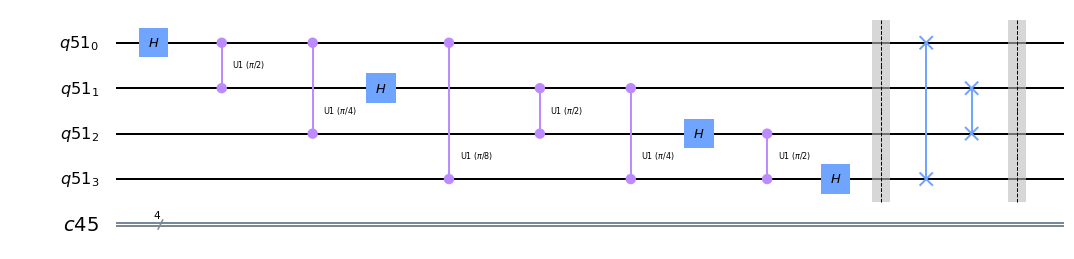

In [119]:
n = 3
qbt1 = QuantumRegister(n)
cbt1 = ClassicalRegister(n)
qbt2 = QuantumRegister(n)
cbt2 = ClassicalRegister(n)
mcq1 = QuantumCircuit(qbt1, cbt1)
mcq2 = QuantumCircuit(qbt2, cbt2)

myQFT(mcq1, n)
mcq1.barrier()
reflect(mcq1, n)
mcq1.barrier()

mcq2.append(QFT(n, do_swaps=True), qbt2)

mcq1.measure(range(n), range(n))
mcq2.measure(range(n), range(n))

backend = BasicAer.get_backend('qasm_simulator')
atp = 1024
res = execute(mcq2, backend=backend, shots=atp).result()
ans1 = res.get_counts()

backend = BasicAer.get_backend('qasm_simulator')
atp = 1024
res = execute(mcq2, backend=backend, shots=atp).result()
ans2 = res.get_counts()

mcq.draw('mpl')

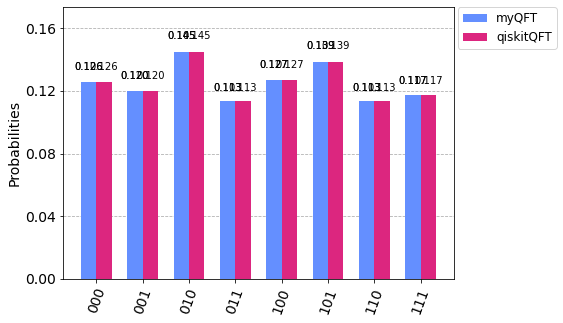

In [120]:
legend = ['myQFT','qiskitQFT']
plot_histogram([ans1,ans2], legend=legend)